# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [38]:
import sys
import inspect
from collections import defaultdict
from contextlib import contextmanager
from itertools import combinations, product
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score
from pylab import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sys.path.append('..')
from py_graphs.graphs.generator import StochasticBlockModel
from py_graphs.measure import *
from py_graphs.measure import H_kernels_plus_RSP_FE
from py_graphs.cluster.ward import Ward
from py_graphs.colors import d3
from py_graphs.scenario import *
from py_graphs.scorer import copeland

In [26]:
def load_or_calc_and_save(filename):
    def my_decorator(func):
        def wrapped():
            if os.path.exists(filename):
                print('File exist! Skip calculations')
                with open(filename, 'rb') as f:
                    result = pickle.load(f)
            else:
                result = func()
                with open(filename, 'wb') as f:
                    pickle.dump(result, f)
            return result
        return wrapped
    return my_decorator

In [27]:
def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

## 4. Reject curves
The optimal values of the family parameters (adjusted to the $[0, 1]$ segment) w.r.t. the ARI in clustering based on Ward’s method for three $G(N,(m)p_{in}, p_{out})$ models are presented in Table 2.

Measure $G(100,(2)0.3,0.05)$, $G(100,(2)0.3,0.1)$, $G(100,(2)0.3,0.15)$

In [11]:
measures = [
    'pWalk H',
    'Walk H',
    'For H',
    'logFor H',
    'Comm H',
    'logComm H',
    'Heat H',
    'logHeat H',
    'SCT H',
    'SCCT H',
    'RSP K',
    'FE K',    
    'SP-CT H'
]
columns = [
    (100, 2, 0.05),
    (100, 2, 0.10),
    (100, 2, 0.15)
]

In [6]:
best_params_raw = {
    'pWalk H':   (0.86, 0.9653, 0.90, 0.8308, 0.66, 0.5298),
    'Walk H':    (0.86, 0.9664, 0.74, 0.8442, 0.64, 0.5357),
    'For H':     (1.00, 0.5816, 0.98, 0.3671, 0.00, 0.2007),
    'logFor H':  (0.62, 0.9704, 0.56, 0.8542, 0.52, 0.5541),
    'Comm H':    (0.38, 0.9761, 0.32, 0.8708, 0.26, 0.5661),
    'logComm H': (0.68, 0.9838, 0.54, 0.9466, 0.62, 0.7488),
    'Heat H':    (0.86, 0.6128, 0.86, 0.5646, 0.78, 0.2879),
    'logHeat H': (0.52, 0.9827, 0.40, 0.8911, 0.28, 0.5561),
    'SCT H':     (0.74, 0.9651, 0.62, 0.8550, 0.64, 0.5531),
    'SCCT H':    (0.36, 0.9834, 0.26, 0.9130, 0.22, 0.6626),
    'RSP K':     (0.99, 0.9712, 0.98, 0.8444, 0.98, 0.5430),
    'FE K':      (0.94, 0.9697, 0.94, 0.8482, 0.86, 0.5460),
    'SP-CT H':   (0.28, 0.9172, 0.34, 0.6782, 0.42, 0.4103)
}

In [7]:
best_params = {
    (100, 2, 0.05): dict([(measure_name, best_params_raw[measure_name][0]) for measure_name in best_params_raw.keys()]),
    (100, 2, 0.10): dict([(measure_name, best_params_raw[measure_name][2]) for measure_name in best_params_raw.keys()]),
    (100, 2, 0.15): dict([(measure_name, best_params_raw[measure_name][4]) for measure_name in best_params_raw.keys()])
}

In [28]:
@load_or_calc_and_save('results/4_best_params.pkl')
def calc():
    # calc data to find best params
    results = defaultdict(lambda: defaultdict(lambda: 0))
    for column in tqdm(list(product([100], [2], [0.05, 0.1, 0.15]))):
        n_nodes, n_classes, p_out = column
        graphs, info = StochasticBlockModel(n_nodes, n_classes, 0.3, p_out).generate_graphs(50)
        classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 31), progressbar=False)
        for measure_class in tqdm(H_kernels_plus_RSP_FE, desc=str(column)):
            results[column][measure_class.name] = classic_plot.perform(Ward, measure_class, graphs, n_classes, n_jobs=6)
            
    # find best params
    best_params = defaultdict(lambda: defaultdict(lambda: 0))
    for column, measures in results.items():
        for measure_name, measure_results in measures.items():
            x, y, error = measure_results
            best_idx = np.argmax(y)
            print('{}\t{}\t{:0.2f} ({:0.2f})'.format(column, measure_name.ljust(8, ' '), x[best_idx], y[best_idx]))
            best_params[column][measure_name] = x[best_idx]
    return ddict2dict(best_params)

best_params = calc()
best_params

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.05)', max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.1)', max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.15)', max=13), HTML(value='')))


(100, 2, 0.05)	SP-CT H 	0.00 (0.99)
(100, 2, 0.05)	logHeat H	0.37 (1.00)
(100, 2, 0.05)	Comm H  	0.33 (1.00)
(100, 2, 0.05)	RSP K   	0.97 (1.00)
(100, 2, 0.05)	SCT H   	0.40 (1.00)
(100, 2, 0.05)	SCCT H  	0.03 (1.00)
(100, 2, 0.05)	logFor H	0.70 (1.00)
(100, 2, 0.05)	pWalk H 	0.93 (1.00)
(100, 2, 0.05)	Walk H  	0.93 (1.00)
(100, 2, 0.05)	FE K    	0.90 (1.00)
(100, 2, 0.05)	Heat H  	0.37 (1.00)
(100, 2, 0.05)	For H   	0.60 (0.99)
(100, 2, 0.05)	logComm H	0.33 (1.00)
(100, 2, 0.15)	SP-CT H 	0.07 (0.49)
(100, 2, 0.15)	logHeat H	0.37 (0.80)
(100, 2, 0.15)	Comm H  	0.30 (0.77)
(100, 2, 0.15)	RSP K   	0.97 (0.67)
(100, 2, 0.15)	SCT H   	0.43 (0.72)
(100, 2, 0.15)	SCCT H  	0.63 (0.80)
(100, 2, 0.15)	logFor H	0.10 (0.68)
(100, 2, 0.15)	pWalk H 	0.73 (0.66)
(100, 2, 0.15)	Walk H  	0.70 (0.65)
(100, 2, 0.15)	FE K    	0.87 (0.68)
(100, 2, 0.15)	Heat H  	0.73 (0.15)
(100, 2, 0.15)	For H   	0.40 (0.01)
(100, 2, 0.15)	logComm H	0.57 (0.91)
(100, 2, 0.1)	SP-CT H 	0.03 (0.78)
(100, 2, 0.1)	logHeat H	

{(100, 2, 0.05): {'Comm H': 0.3333333333333333,
  'FE K': 0.9,
  'For H': 0.6,
  'Heat H': 0.36666666666666664,
  'RSP K': 0.9666666666666667,
  'SCCT H': 0.03333333333333333,
  'SCT H': 0.4,
  'SP-CT H': 0.0,
  'Walk H': 0.9333333333333333,
  'logComm H': 0.3333333333333333,
  'logFor H': 0.7,
  'logHeat H': 0.36666666666666664,
  'pWalk H': 0.9333333333333333},
 (100, 2, 0.1): {'Comm H': 0.3333333333333333,
  'FE K': 0.9,
  'For H': 0.9666666666666667,
  'Heat H': 0.6,
  'RSP K': 0.9666666666666667,
  'SCCT H': 0.5666666666666667,
  'SCT H': 0.5666666666666667,
  'SP-CT H': 0.03333333333333333,
  'Walk H': 0.6666666666666666,
  'logComm H': 0.4666666666666667,
  'logFor H': 0.4,
  'logHeat H': 0.5333333333333333,
  'pWalk H': 0.8666666666666667},
 (100, 2, 0.15): {'Comm H': 0.3,
  'FE K': 0.8666666666666667,
  'For H': 0.4,
  'Heat H': 0.7333333333333333,
  'RSP K': 0.9666666666666667,
  'SCCT H': 0.6333333333333333,
  'SCT H': 0.43333333333333335,
  'SP-CT H': 0.06666666666666667,
 

In [33]:
def reject_curve(K, y_true):
    y_true_combinations = [0 if a == b else 1 for a, b in combinations(y_true, 2)]
    K_combinations = [K[a, b] for a, b in combinations(range(K.shape[0]), 2)]
    pairs = sorted(zip(K_combinations, y_true_combinations), key=lambda x: x[0])
    tpr, fpr = [0], [0]
    for _, class_ in pairs:
        if class_ == 1:
            increment = 1, 0
        else:
            increment = 0, 1
        tpr.append(tpr[-1] + increment[0])
        fpr.append(fpr[-1] + increment[1])
#     print(tpr)
#     raise Exception()
    return np.array(tpr, dtype=np.float) / tpr[-1], np.array(fpr, dtype=np.float) / fpr[-1]

In [34]:
results = defaultdict(lambda: defaultdict(lambda: list()))
for column in tqdm(best_params.keys()): 
    n_nodes, n_classes, p_out = column
    graphs, info = StochasticBlockModel(n_nodes, n_classes, 0.3, p_out).generate_graphs(60)
    for edges, nodes in tqdm(graphs, desc=str(column)):
        single_competition_best = {}
        for kernel_class in H_kernels_plus_RSP_FE:
            best_param = best_params[column][kernel_class.name]
            kernel = kernel_class(edges)
            K = kernel.get_K(best_param)
            tpr, fpr = reject_curve(K, nodes)
            results[column][kernel_class.name].append((tpr, fpr))

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.1)', max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.15)', max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, description='(100, 2, 0.05)', max=60), HTML(value='')))

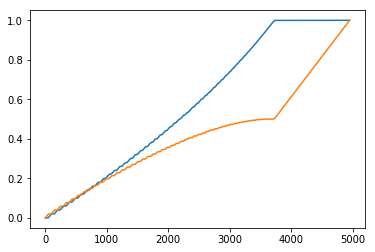

In [35]:
plt.plot(results[(100, 2, 0.05)]['Walk H'][0][0])
plt.plot(results[(100, 2, 0.05)]['Walk H'][0][1])

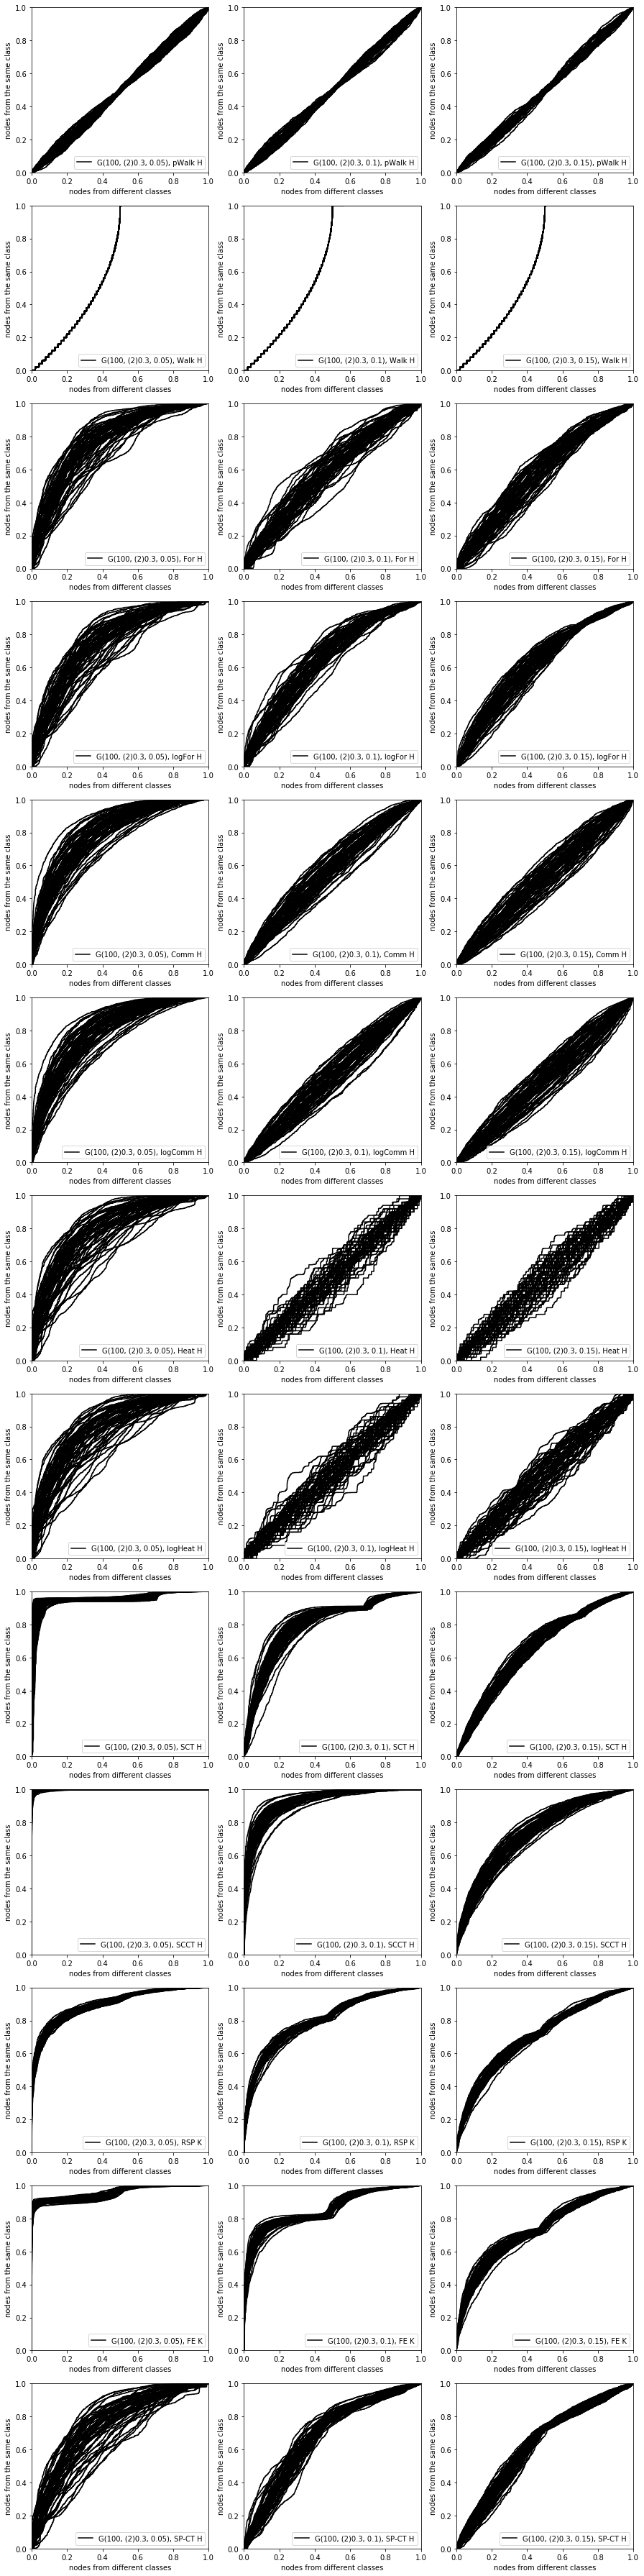

In [41]:
fig, ax = plt.subplots(13, 3, figsize=(15,65))
for column_idx, column in enumerate(columns):
    for measure_name_idx, measure_name in enumerate(measures):
        axi = ax[measure_name_idx][column_idx]
        for graph_idx, (tpr, fpr) in enumerate(results[column][measure_name]):
            if graph_idx == 1:
                axi.plot(fpr, tpr, label="G({}, ({})0.3, {}), {}".format(*column, measure_name), color='black')
            else:
                axi.plot(fpr, tpr, color='black')

        axi.set_xlabel("nodes from different classes")
        axi.set_ylabel("nodes from the same class")
        axi.set_xlim(0,1)
        axi.set_ylim(0,1)
        axi.legend(loc=4)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

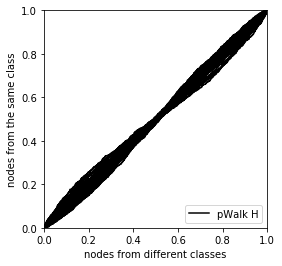

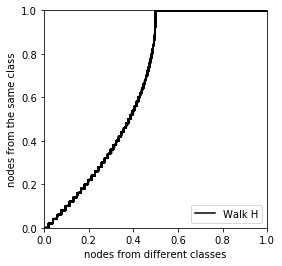

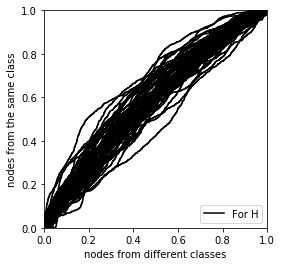

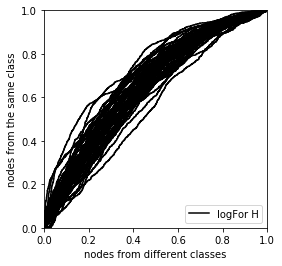

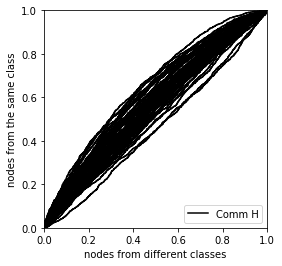

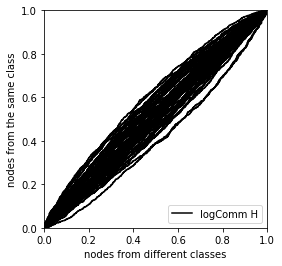

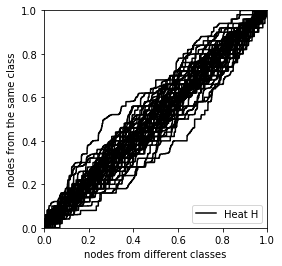

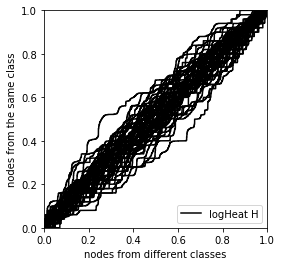

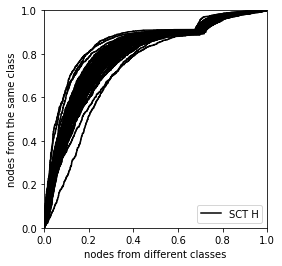

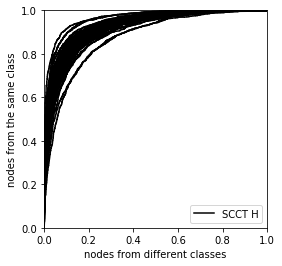

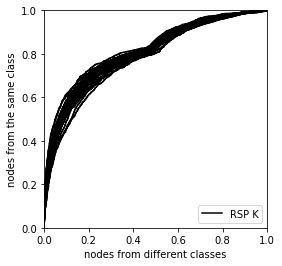

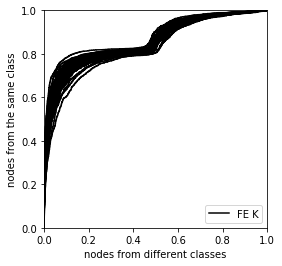

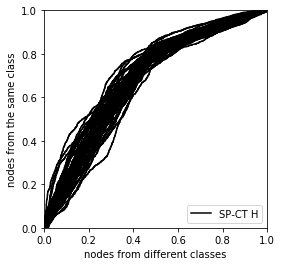

In [42]:
for measure_name_idx, measure_name in enumerate(measures):
    fig, axi = plt.subplots(1, figsize=(4, 4))
    for graph_idx, (tpr, fpr) in enumerate(results[(100, 2, 0.10)][measure_name]):
        if graph_idx == 1:
            axi.plot(fpr, tpr, label=measure_name, color='black')
        else:
            axi.plot(fpr, tpr, color='black')

    axi.set_xlabel("nodes from different classes")
    axi.set_ylabel("nodes from the same class")
    axi.set_xlim(0,1)
    axi.set_ylim(0,1)
    axi.legend(loc=4)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");